# EOF解析

* 経験的直交函数 (Empirical Orthogonal Functions) 
* 少ない次元で変動を表現（データの要約）
* 分散（ばらつき）最大の方向を求める。
* 線型代数学の固有値分解，統計学の主成分分析（PCA, Principal Component Analysis）

## 2次元の例

In [1]:
import numpy as np
import netCDF4 as nc4
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [2]:
x = np.array([1, 2, -3, 4])
y = x * 2
X = np.array([x, y]).transpose()
m, n = X.shape
print(m, n)

4 2


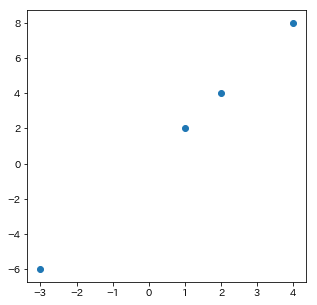

In [3]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X[:, 0], X[:, 1])

In [4]:
X = (X - X.mean(axis=0)) / X.std(axis=0)

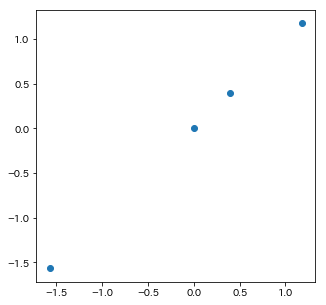

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X[:, 0], X[:, 1])

In [6]:
print(X.mean(), X.std())

0.0 1.0


In [7]:
U, s, V = np.linalg.svd(X)

In [8]:
U

array([[ 0.        , -0.19611614,  0.78446454, -0.58834841],
       [-0.19611614,  0.96153846,  0.15384615, -0.11538462],
       [ 0.78446454,  0.15384615,  0.38461538,  0.46153846],
       [-0.58834841, -0.11538462,  0.46153846,  0.65384615]])

In [9]:
U @ U.transpose()

array([[ 1.00000000e+00,  8.32667268e-17, -1.45716772e-16,
         5.89805982e-17],
       [ 8.32667268e-17,  1.00000000e+00, -3.46944695e-17,
        -1.38777878e-17],
       [-1.45716772e-16, -3.46944695e-17,  1.00000000e+00,
         1.11022302e-16],
       [ 5.89805982e-17, -1.38777878e-17,  1.11022302e-16,
         1.00000000e+00]])

In [10]:
V

array([[-0.70710678, -0.70710678],
       [-0.70710678,  0.70710678]])

In [11]:
V @ V.transpose()

array([[1., 0.],
       [0., 1.]])

In [12]:
s * s / n

array([4., 0.])

元に戻るか$\mathsf{X} = \mathsf{U}\Sigma\mathsf{V^T}$を計算

In [13]:
smat = np.zeros((m, n))
smat[:n, :n] = np.diag(s)
np.allclose(X, U @ (smat @ V))

True

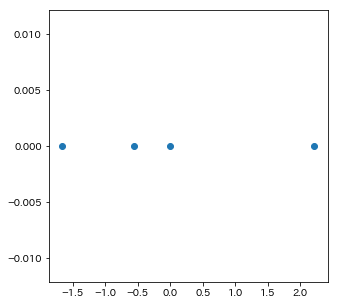

In [14]:
V = V.transpose()
X = X @ V
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X[:, 0], X[:, 1])

## 乱数を使った例

In [15]:
m = 100
x = np.random.randn(m)
y = x + np.random.rand(m)

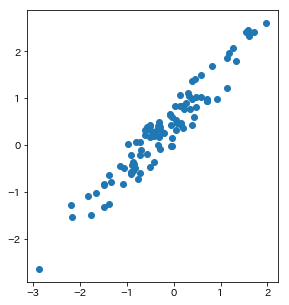

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x, y)
ax.set_aspect('equal')

正規化乱数だがサンプル数が多くないので，正規化は必要。

In [17]:
X = np.array([x, y]).transpose()
X = (X - X.mean()) / X.std()
x = X[:,0]
y = X[:,1]

In [18]:
X.shape

(100, 2)

SVD解析を実行する。

In [19]:
U, s, V = np.linalg.svd(X)

In [20]:
V = V.transpose()

In [21]:
V

array([[-0.68042149,  0.73282099],
       [-0.73282099, -0.68042149]])

散布図に主成分を描いてみよう。

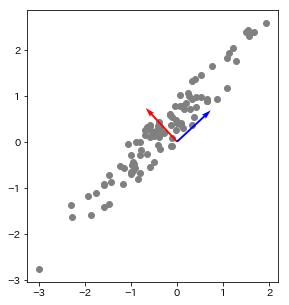

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x, y, color='gray')
ax.quiver(V[0,0], V[0,1], units='xy', angles='xy', scale=1, color='r')
ax.quiver(-V[1,0], -V[1,1], units='xy', angles='xy', scale=1, color='b')
ax.set_aspect('equal')

回転してデータの圧縮を確認。

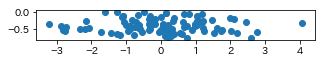

In [23]:
X = X @ V
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X[:, 0], X[:, 1])
ax.set_aspect('equal')

# 1月の海面気圧のEOF解析

## 関連リンク
* 京大生存研NCEP/NCAR再解析地表面統計処理データ http://database.rish.kyoto-u.ac.jp/arch/ncep/data/ncep.reanalysis.derived/surface/
* Numpy svdドキュメント https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html#numpy.linalg.svd

## データの読み込み

月平均の海面気圧（slp）から1月のみを切り出したファイル（ https://github.com/tenomoto/dsss2018/blob/master/slp_jan_mean.nc ）をダウンロードする。


In [24]:
f = nc4.Dataset('slp_jan_mean.nc')
list(f.dimensions)

['time', 'lon', 'lat']

座標軸を読む。

In [25]:
lon = f.variables['lon'][:]
lat = f.variables['lat'][:]
time = f.variables['time'][:]
list(f.variables)

['time', 'lon', 'lat', 'slp']

気圧を読む。

In [26]:
slp = f.variables['slp']
print(slp)

<class 'netCDF4._netCDF4.Variable'>
float32 slp(time, lat, lon)
    long_name: Sea Level Pressure
    units: millibars
    _FillValue: -9.96921e+36
    missing_value: -9.96921e+36
    precision: 1
    least_significant_digit: 1
    var_desc: Sea Level Pressure
    level_desc: Sea Level
    statistic: Mean
    parent_stat: Other
    dataset: NCEP Reanalysis Derived Products
    actual_range: [ 955.56085 1082.5582 ]
unlimited dimensions: time
current shape = (71, 73, 144)
filling off



描画関数を作っておこう。

In [27]:
def plot_nps(lon, lat, data):
    datac, lonc = add_cyclic_point(data, coord=lon)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
    p = ax.contourf(lonc, lat, datac, transform=ccrs.PlateCarree())
    ax.set_extent([0, 359.999, 20, 90], ccrs.PlateCarree())
    fig.colorbar(p)
    ax.coastlines()

最初の年を描画して確認。警告は無視してよい。

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


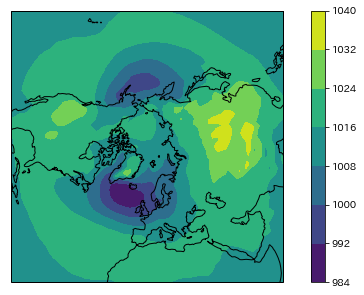

In [28]:
plot_nps(lon, lat, slp[0])

## 統計値の計算
気候値（時間平均）

In [29]:
slp_clim = np.mean(slp, axis=0)
slp_clim.shape

(73, 144)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


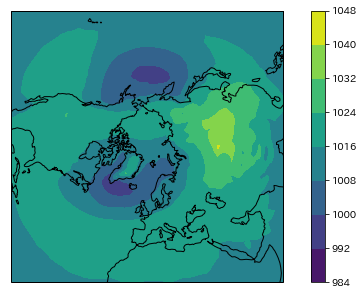

In [30]:
plot_nps(lon, lat, slp_clim)

北太平洋にアリューシャン低気圧，北大西洋にアイスランド低気圧，ユーラシア大陸にシベリア高気圧が現れた。

標準偏差

In [31]:
slp_stddev = np.std(slp, axis=0)
slp_stddev.shape

(73, 144)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


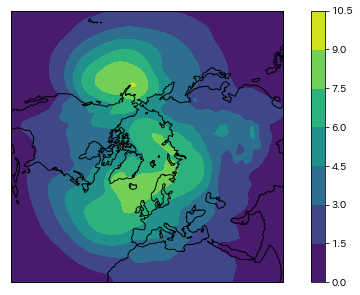

In [32]:
plot_nps(lon, lat, slp_stddev)

アリューシャン低気圧とアイスランド低気圧の変動が大きい。

## データの前処理
極に近づくほど東西格子間隔が狭まることを考慮して，緯度の重み$\sqrt{\cos\phi}$を掛ける。

In [33]:
wgt = np.sqrt(np.abs(np.cos(np.deg2rad(lat[:]))))

Thompson and Wallace (1998)に基づき，北緯20度以北の海面気圧を用いる。

In [34]:
dslp = (slp - slp_clim) / slp_stddev
X = dslp * wgt[None, :, None]
X = X[:,np.where(lat > 20)[0],:].reshape(time.size,-1).transpose()
m, n = X.shape
print(m, n)

4032 71


## 特異値分解

In [35]:
U, s, V = np.linalg.svd(X)

寄与率

In [36]:
contrib = (s * s) / (s @ s) * 100

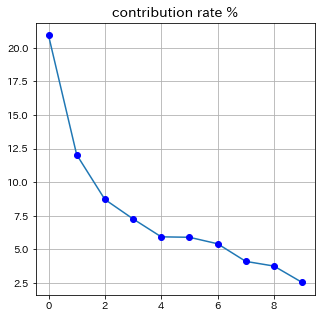

In [37]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(contrib[0:10])
ax.plot(contrib[0:10],'bo')
ax.set_title("contribution rate %", fontsize=14)
ax.grid()

回帰

In [38]:
D = (dslp.reshape(time.size,-1).transpose() @ V.transpose()).transpose().reshape(time.size, lat.size, lon.size)
D.shape

(71, 73, 144)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


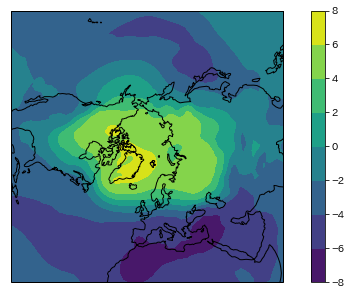

In [39]:
plot_nps(lon, lat, D[0])

## 固有値分解
共分散行列の固有値分解でも同じになるか確認しよう。

In [40]:
cov = (X.transpose() @ X) / n
W, V_eig = np.linalg.eig(cov)
W.shape; V_eig.shape

(71, 71)

In [41]:
D_eig = (dslp.reshape(time.size,-1).transpose() @ V_eig).transpose().reshape(time.size, lat.size, lon.size)
D_eig.shape

(71, 73, 144)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


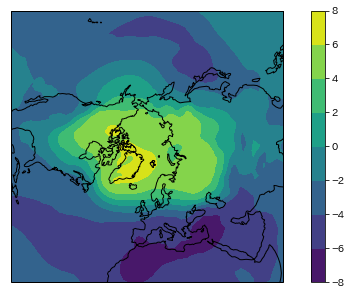

In [42]:
plot_nps(lon, lat, D_eig[0])